In [1]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-nandiinii')

In [2]:
# Bands considered as
band_names = ee.List(['B2', 'B3','B4','B5','B6','B7','B10','B11'])

In [6]:
region = ee.Geometry.Polygon([
    [[-122.6, 37.0], [-122.6, 37.5], [-122.0, 37.5], [-122.0, 37.0]]
])

In [3]:
# Load a landst 8 image and select the bands of intrest
image = ee.Image('LANDSAT/LC08/C02/T1/LC08_044034_20140318').select(band_names)

In [7]:
# Display the input image and the region
n = geemap.Map()
n.center_object(region, 10)
n.add_layer(ee.Image().paint(region, 0, 2), {}, 'Region')
n.add_layer(
    image,
    {'bands': ['B5', 'B4', 'B2'], 'min': 0, 'max': 20000},
    'Original Image',
)
display(n)

Map(center=[37.25010190902647, -122.29999999999983], controls=(WidgetControl(options=['position', 'transparent…

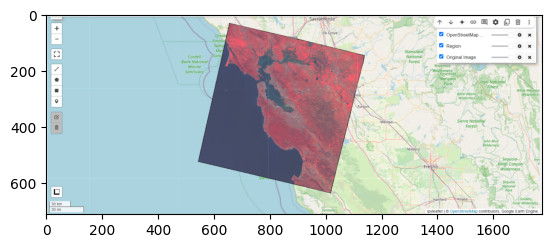

In [8]:
import matplotlib.pyplot as plt
img=plt.imread('/content/drive/MyDrive/Colab Notebooks/Screenshot 2025-04-27 204509.png')
plt.imshow(img)

In [9]:
# Set an appropriate scale for the landsat data
scale=30

In [10]:
# Mean center the data to enable faster covariance calculation and SD stretch
mean_dict = image.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=scale,
    maxPixels=1e9
)
means = mean_dict.toImage(band_names)
centered = image.subtract(means)

In [11]:
# This helper function returns a list of new band names
def get_new_band_names(prefix):
    seq = ee.List.sequence(1, band_names.length())
    def add_prefix_and_number(b):
        return ee.String(prefix).cat(ee.Number(b).int())
    return seq.map(add_prefix_and_number)

In [12]:
# This function accepts mean centered imagery, a scale, and a region
# Performs PCA and returns principal components as a new image
def get_principal_components(centered, scale, region):
    # Collapse bands into 1D array
    arrays = centered.toArray()

    # Compute the covariance of the bands within the region
    covar = arrays.reduceRegion(
        reducer=ee.Reducer.centeredCovariance(),
        geometry=region,
        scale=scale,
        maxPixels=1e9
    )

    # Get the covariance 'array' object
    covar_array = ee.Array(covar.get('array'))

    # Compute eigenvalues and eigenvectors
    eigens = covar_array.eigen()
    eigen_values = eigens.slice(1, 0, 1)
    eigen_vectors = eigens.slice(1, 1)

    # Project centered image into the space of eigenvectors
    array_image = arrays.toArray(1)
    principal_components = ee.Image(eigen_vectors).matrixMultiply(array_image)

    # Standard deviation image
    sd_image = (
        ee.Image(eigen_values.sqrt())
        .arrayProject([0])
        .arrayFlatten([get_new_band_names('sd')])
    )

    # Return principal components normalized by their standard deviations
    return (
        principal_components
        .arrayProject([0])
        .arrayFlatten([get_new_band_names('pc')])
        .divide(sd_image)
    )

In [13]:
# Get the principal components image
pc_image = get_principal_components(centered, scale, region)


In [14]:
# Add principal components layers to the map
for i in range(1, band_names.length().getInfo() + 1):
    pc_band = 'pc' + str(i)
    n.add_layer(
        pc_image.select(pc_band),
        {'min': -2, 'max': 2},
        pc_band
    )

In [15]:
# Display the final map
display(n)

Map(bottom=102100.0, center=[37.25656608611523, -122.28258709940735], controls=(WidgetControl(options=['positi…

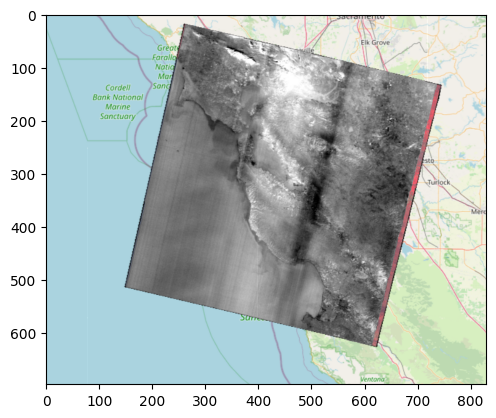

In [16]:
import matplotlib.pyplot as plt
img=plt.imread('/content/drive/MyDrive/Colab Notebooks/Screenshot 2025-04-27 205100.png')
plt.imshow(img)